In [1]:
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

In [3]:
# load file

file = '../data/uniprot_sprot.fasta'
with open(file, 'r') as f:
    lines = [line.strip() for line in f.readlines()]

protein, proteins = '', list()
skip_tag = True
total_count, human_count = 0, 0
for line in lines:
    if line.startswith('>'): # start of a protein
        total_count += 1
        if 'OS=Homo sapiens' in line: # human protein
            human_count += 1
            skip_tag = True
        else: # non-human protein
            skip_tag = False
        if (not skip_tag) and (protein != ''): # append protein sequence
            proteins.append(protein)
        protein = ''
    else:
        protein += line

# last protein
if not skip_tag: # append protein sequence
    proteins.append(protein)

print('Total number of proteins:', total_count)
print('Number of human protiens:', human_count)
print('Number of left proteins: ', len(proteins))

Total number of proteins: 568744
Number of human protiens: 20405
Number of left proteins:  548339


In [4]:
# check duplication

proteins = list(set(proteins))
print('Number of duplicates:   ', total_count-human_count-len(proteins))
print('Number of left proteins:', len(proteins))

Number of duplicates:    87498
Number of left proteins: 460841


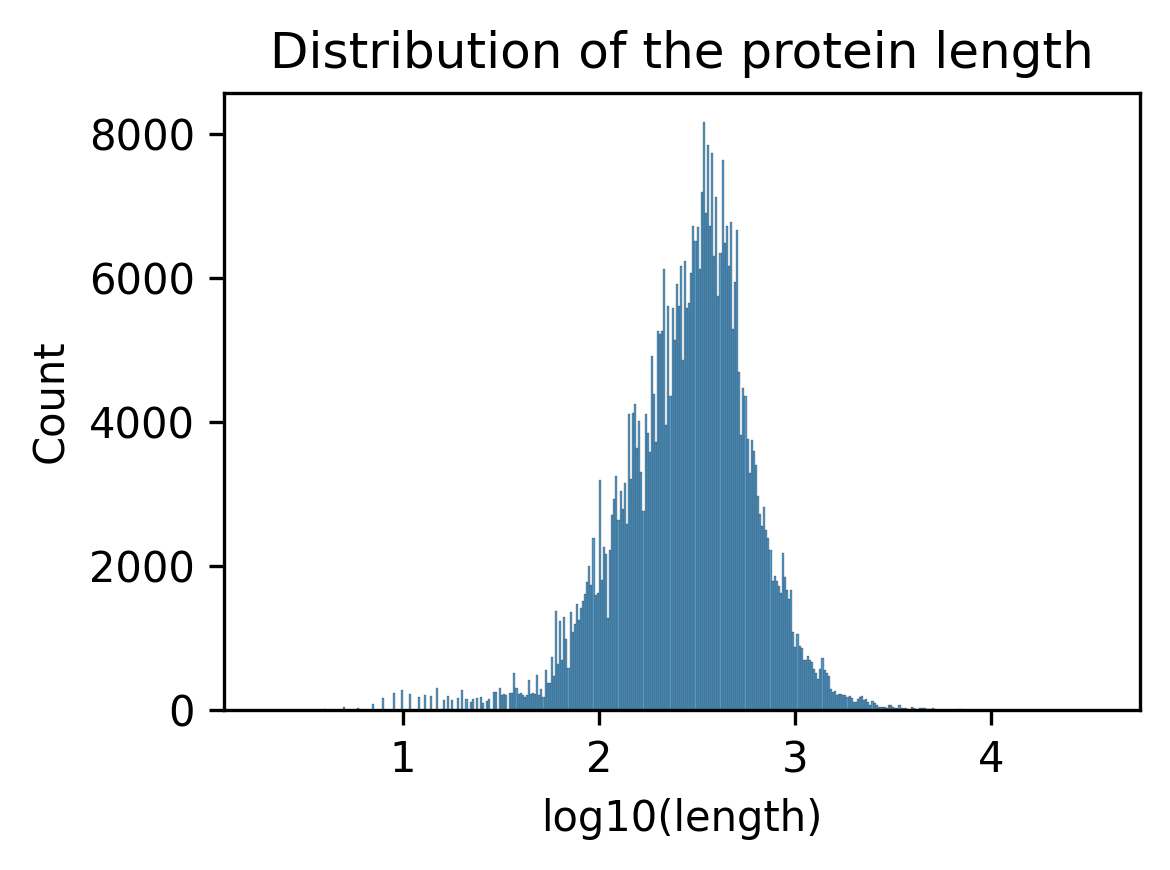

In [5]:
# protein length

# log10(length)
log_lengths = np.array([np.log10(len(protein)) for protein in proteins])

# histogram
fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi=300)
sns.histplot(log_lengths, ax=ax)
ax.set_title('Distribution of the protein length')
ax.set_xlabel('log10(length)')
fig.tight_layout()
fig.savefig('figs/log_prot_length.hist.png')

In [6]:
# filter by length

# keep proteins with length within specific range
min_log_len, max_log_len = 1, 4
keep_idx = np.where((log_lengths >= min_log_len) & (log_lengths <= max_log_len))[0]
proteins = [proteins[i] for i in keep_idx]
print('The number of proteins with length in 10^1 - 10^4:', len(keep_idx))

The number of proteins with length in 10^1 - 10^4: 460241


In [7]:
# distribution of motifs

aa_list = list('ACDEFGHIKLMNPQRSTVWY') # acceptable 20 a.a.
k = 9 # motif length

motif_dict = defaultdict(int)
for i in tqdm(range(len(proteins))): # for each protein
    protein = proteins[i] # protein
    length = len(protein) # length
    if length < k:
        continue
    
    motifs = list() # motif set
    for j in range(length-k+1): # for each k-mer
        if (protein[j+1] not in aa_list) or (protein[j+k-1] not in aa_list): # check valid a.a.
            continue
        motifs.append('{}-{}'.format(protein[j+1], protein[j+k-1])) # append to motif set
    motifs = list(set(motifs)) # unique motifs
    
    for motif in motifs: # append to motif count dict
        motif_dict[motif] += 1
        
motif_df = pd.Series(motif_dict)
motif_df.sort_values(ascending=False, inplace=True)
motif_df = pd.DataFrame({'motif':motif_df.index, 'frequency':motif_df.values})
motif_df['coverage'] = motif_df['frequency'] / len(proteins)

100%|██████████| 460241/460241 [01:26<00:00, 5336.22it/s]


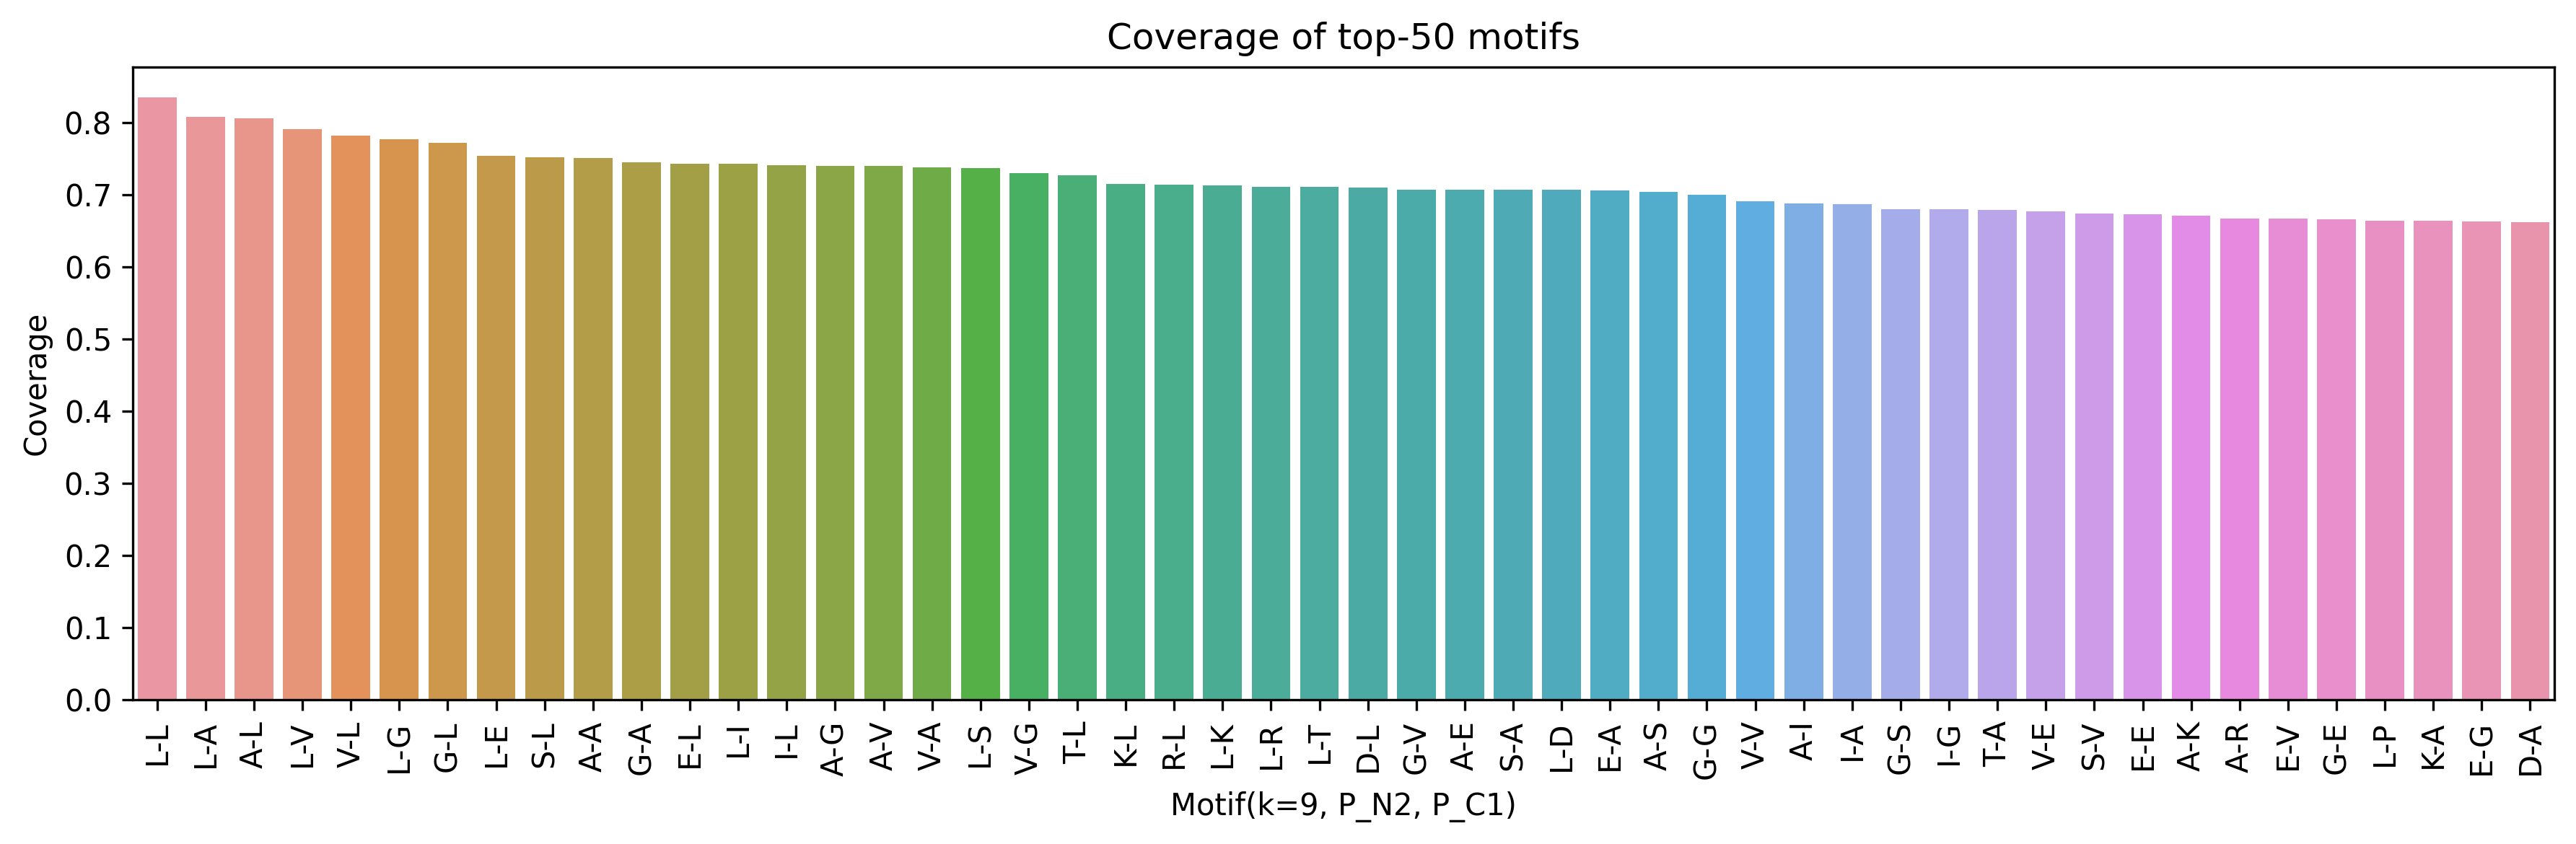

In [8]:
# top-n motifs

fig, ax = plt.subplots(1, 1, figsize=(12,4), dpi=300)
n = 50
sns.barplot(data=motif_df.iloc[:n], x='motif', y='coverage', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Coverage of top-{} motifs'.format(n))
ax.set_xlabel('Motif(k={}, P_N2, P_C1)'.format(k))
ax.set_ylabel('Coverage')
fig.tight_layout()
fig.savefig('figs/top{}_coverage.k{}.bar.png'.format(n, k))

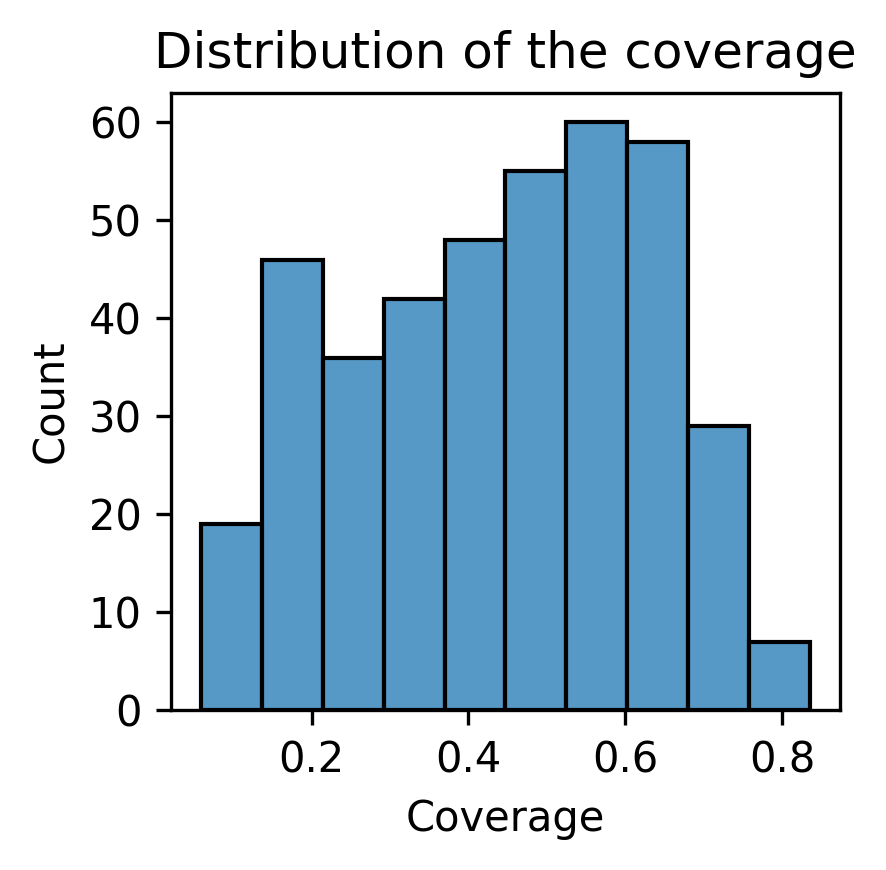

In [9]:
# distribution of the coverage

fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=300)
sns.histplot(data=motif_df, x='coverage', ax=ax)
ax.set_title('Distribution of the coverage')
ax.set_xlabel('Coverage')
fig.tight_layout()
fig.savefig('figs/coverage.k{}.hist.png'.format(n, k))

In [10]:
# save proteins

json.dump(proteins, open('../data/proteins.json', 'w'))